In [28]:
import h5py
import numpy as np
import os

filepath3 = "/home/csverst/Github/InterpretabilityBenchmark/datasets/dt/20240214_NBFF_DSA_Comparison_Final_Redux_3BFF_model_GRU_RNN_n_neurons_50_seed_0/"
filepath4 = "/home/csverst/Github/InterpretabilityBenchmark/datasets/dt/20240214_NBFF_DSA_Comparison_Final_Redux_4BFF_model_GRU_RNN_n_neurons_50_seed_0/"

In [37]:
latent_list = []
hp_list = []
subdirs3 = [f.path for f in os.scandir(filepath3) ]
subdirs4 = [f.path for f in os.scandir(filepath4)]


for subdir in subdirs3:
    hp_temp0 = subdir[:-3].split("/")[-1]
    hp_temp = hp_temp0.split(" ")
    hp_temp1 = [x.split("=") for x in hp_temp]
    hp_list.append(hp_temp1)
    lat_size = hp_temp1[0][1]
    with h5py.File(subdir, "r") as f:
        latent_list.append(np.array(f["train_latents"])[:,:,0:int(lat_size)])
for subdir in subdirs4:
    hp_temp0 = subdir[:-3].split("/")[-1]
    hp_temp = hp_temp0.split(" ")
    hp_temp1 = [x.split("=") for x in hp_temp]
    hp_list.append(hp_temp1)
    lat_size = hp_temp1[0][1]
    with h5py.File(subdir, "r") as f:
        latent_list.append(np.array(f["train_latents"])[:,:,0:int(lat_size)])


6


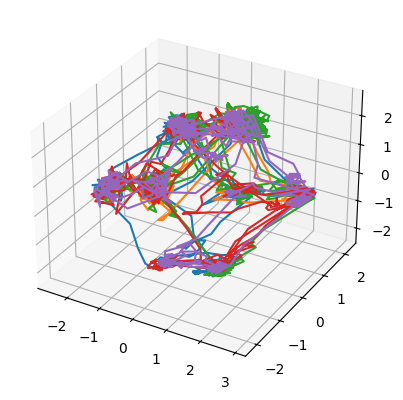

In [40]:
from matplotlib import pyplot as plt
# import PCA
from sklearn.decomposition import PCA
print(len(hp_list))
lats1 = latent_list[0]
pca = PCA(n_components=3)
pca.fit(lats1.reshape(-1, lats1.shape[-1]))
lats1_pca = pca.transform(lats1.reshape(-1, lats1.shape[-1]))
lats1_pca = lats1_pca.reshape(lats1.shape[0], lats1.shape[1], -1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(5):
    ax.plot(lats1_pca[i,:,0], lats1_pca[i,:,1], lats1_pca[i,:,2])

In [31]:

from DSA import DSA
downsample_factor = 50
latent_list_down = [latent[::downsample_factor] for latent in latent_list]
print(latent_list_down[0].shape)
dsa = DSA(
    latent_list_down,
    n_delays=16,
    rank=300,
    delay_interval=5,
    verbose=True,
    device='cuda',
    iters=1500,
    lr=0.005,
)
similarities = dsa.fit_score()


(16, 500, 32)
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squa

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

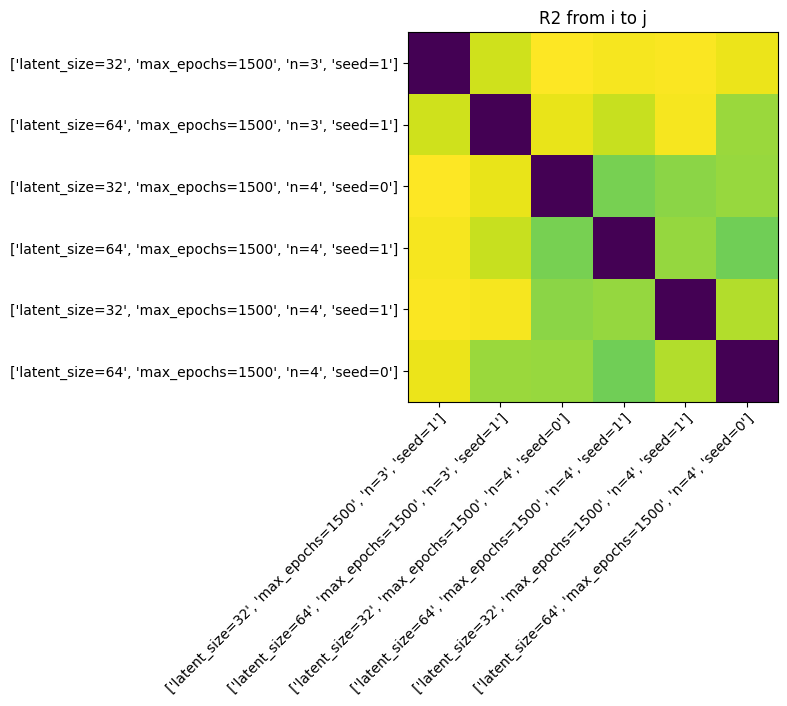

In [38]:
from matplotlib import pyplot as plt
label_list = []
fit_mat = similarities
ij_figure = plt.figure()
ij_ax = ij_figure.add_subplot(111)
# Plot it as an image
ij_ax.imshow(fit_mat)
ij_ax.set_title("R2 from i to j")
ij_ax.set_xticks(np.arange(len(latent_list)))
ij_ax.set_yticks(np.arange(len(latent_list)))
for i in range(len(latent_list)):
    hp_temp = hp_list[i]
    label_temp = [hp[0] + "=" + hp[1] for hp in hp_temp]
    label_list.append(label_temp)

ij_ax.set_xticklabels(label_list)
ij_ax.set_yticklabels(label_list)
# Rotate the tick labels and set their alignment.
plt.setp(
    ij_ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
)